In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
from numpy.random import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

In [2]:
def format3D(axis, labels=('x', 'y', 'z'), limits=None):
    """3D plot helper function to set labels, pane color, and axis limits"""
    axis.set_xlabel('\n${}$'.format(labels[0]), linespacing=3)
    axis.set_ylabel('\n${}$'.format(labels[1]), linespacing=3)
    axis.set_zlabel('\n${}$'.format(labels[2]), linespacing=3)
    transparent = (1.0, 1.0, 1.0, 0.0)
    axis.w_xaxis.set_pane_color(transparent)
    axis.w_yaxis.set_pane_color(transparent)
    axis.w_zaxis.set_pane_color(transparent)
    if limits:
        axis.set_xlim(limits[0])
        axis.set_ylim(limits[1])
        axis.set_zlim(limits[2])

### 2D Cluster Demo

In [3]:
n_points = 250
n_dimensions = 2
cluster_centers = 3
cluster_std = 2
data, cluster = make_blobs(n_samples=n_points, 
                           n_features=n_dimensions, 
                           centers=cluster_centers, 
                           cluster_std=cluster_std, 
                           random_state=42)
x, y = data.T

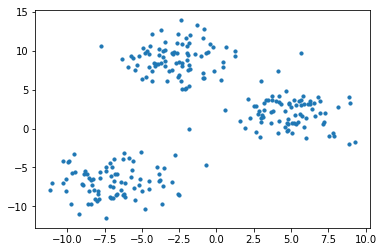

In [4]:
plt.figure()
plt.scatter(x, y, s=10);

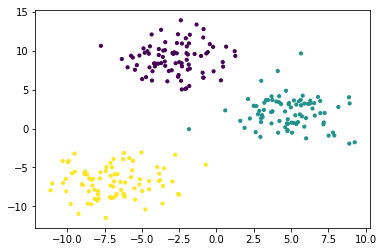

In [5]:
plt.figure()
plt.scatter(x, y, c=cluster, s=10);

### 3D Cluster Demo

In [6]:
n_dimensions = 3
data, cluster = make_blobs(n_samples=n_points, 
                           n_features=n_dimensions, 
                           centers=cluster_centers, 
                           cluster_std=cluster_std, 
                           random_state=42)
x, y, z = data.T

In [7]:
df = pd.DataFrame({'x':x, 'y': y, 'z': z, 'cluster': cluster})
df.groupby('cluster').apply(lambda x: x.iloc[:2]).drop('cluster', axis=1).reset_index(-1, drop=True).to_csv('cluster_demo.csv')

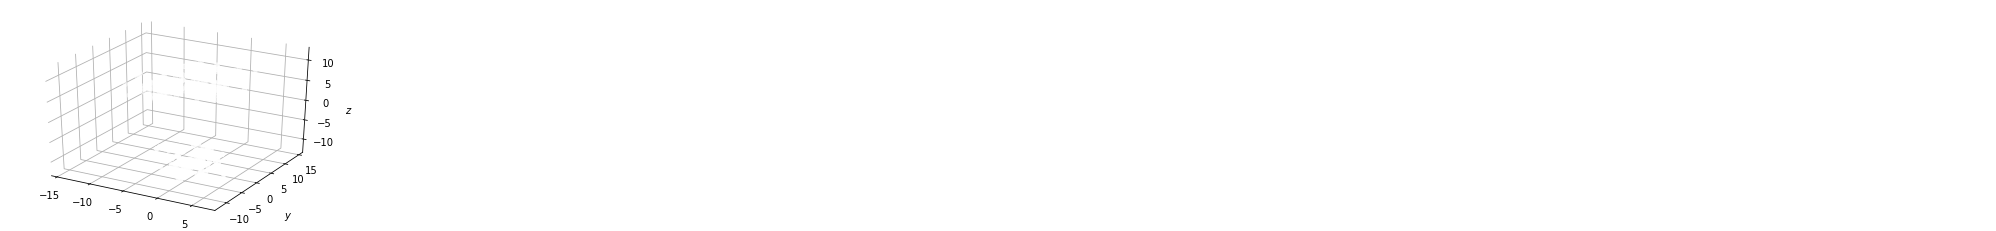

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='white')
format3D(ax)
# plt.tight_layout();

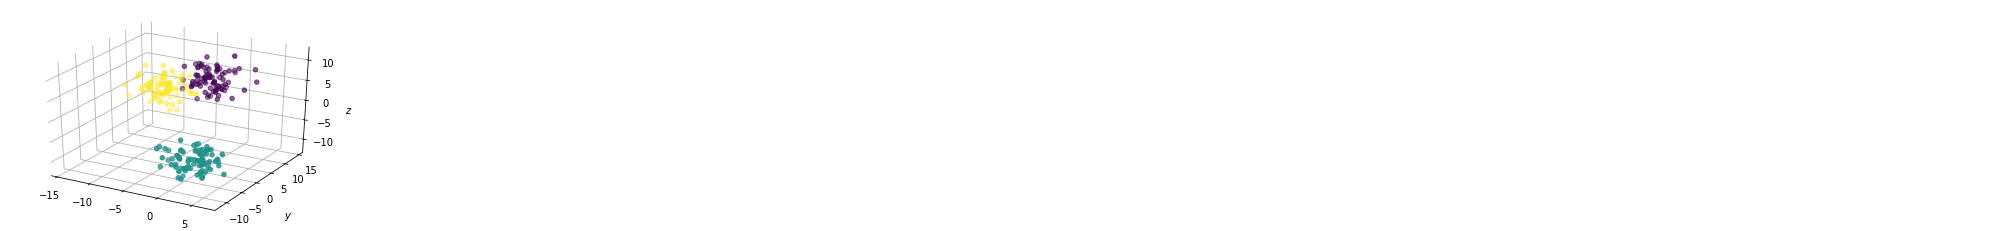

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=cluster)
format3D(ax)
# plt.tight_layout();

### Clustering vs PCA

In [12]:
pca = PCA(n_components=2)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
C = pca.components_.T# columns = principal components
proj_matrix = C.dot(inv(C.T.dot(C))).dot(C.T)
data_2D = data.dot(C)

min_, max_ = data[:, :2].min(), data[:, :2].max()
xs, ys = np.meshgrid(np.linspace(min_,max_, n_points), 
                     np.linspace(min_,max_, n_points))

normal_vector = np.cross(pca.components_[0], 
                         pca.components_[1])
d = -pca.mean_.dot(normal_vector)
zs = (-normal_vector[0] * xs - normal_vector[1] * ys - d) * 1 / normal_vector[2]

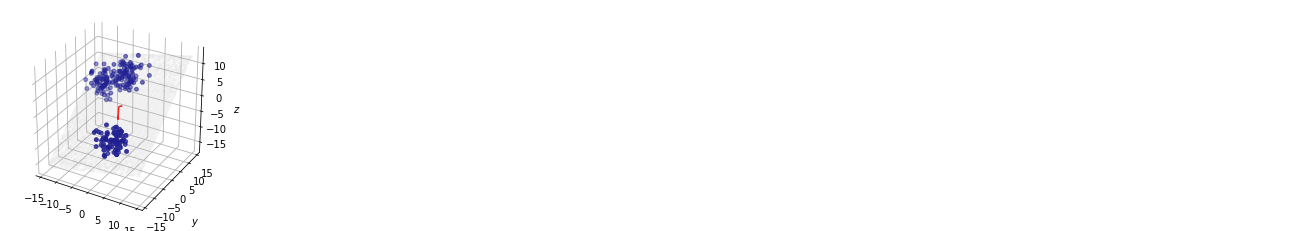

In [15]:
ax = plt.figure().gca(projection='3d')
ax.set_aspect('equal')

ax.plot_surface(xs, ys, zs, alpha=0.2, color='white')
ax.scatter(x, y, z, c='darkblue', s=15)

for i in range(n_points):
    ax.plot(*zip(proj_matrix.dot(data[i]), data[i]), color='white', lw=0.5)

C[:, 0] *= 2
X, Y, Z, U, V, W = zip(*np.hstack((np.zeros((2, 3)), C.T)))
ax.quiver(X, Y, Z, U, V, W, color='red')
format3D(ax)
# plt.tight_layout();

### 2D PCA Projection

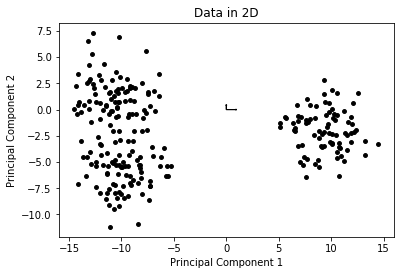

In [17]:
data_3D_inv = pca.inverse_transform(data_2D)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', 
                     xlabel='Principal Component 1', 
                     ylabel='Principal Component 2', 
                     title='Data in 2D')

ax.scatter(data_2D[:, 0], data_2D[:, 1], color='k', s=15)
ax.arrow(0, 0, 0, .5, head_width=0.1, length_includes_head=True, 
         head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.1, length_includes_head=True,
         head_length=0.1, fc='k', ec='k')
# fig.tight_layout()

### Soft Assignments

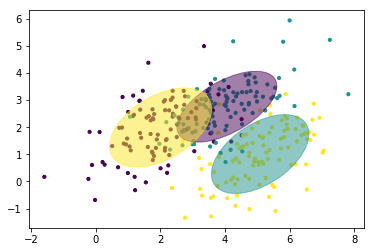

In [18]:
cluster_distributions = [([2, 2], [[1, .5], [.5, 1]]),
                         ([4, 3], [[1, .5], [.5, 1]]),
                         ([5, 1], [[1, .5], [.5, 1]])]
            
clusters = pd.DataFrame()
for c, (mean, cov) in enumerate(cluster_distributions):
    df = pd.DataFrame(multivariate_normal(mean, cov, size=100), columns=['x', 'y']).assign(cluster=c)
    clusters = clusters.append(df)
x, y, c = clusters.values.T
fig, ax = plt.subplots()
ax.scatter(x=x, y=y, c=c, s=10);
components = 3
gmm = GaussianMixture(n_components=components)
gmm.fit(clusters)
for n in range(components):
    c = n + 1
    covariances = gmm.covariances_[n][:2, :2]
    eigen_vec, eigen_val = np.linalg.eigh(covariances)
    u = eigen_val[0] / np.linalg.norm(eigen_val[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(eigen_vec)
    ell = Ellipse(gmm.means_[n, :2], v[0], v[1], 180 + angle, color=plt.cm.viridis(n/(components-1)), alpha=.8)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)